# Challange Data Analytics
## Data Viz y Preprocessing

**Autor:** Juan Bautista Sirai

**Fecha:** 18/04/2021

<img src=https://eant.tech/data_cursos_carreras/carreras/1_tecnico_en_ciencias_de_datos/carrera-t%C3%A9cnico-en-data-mining-y-machine-learning.jpg>

## Intro
En la presente notebook, se realiza un pre procesamiento de datos de clientes y ventas de un comercio ficticio, para finalmente desarrollar un dashboard en tableau con el dataset final.


## Indice

* [1.0 Importación del Dataset y Validación de Datos](#First)
* [2.0 Modelado de Datos](#Modelado)
    * [2.1 Fechas](#Fechas)
    * [2.2 Nuevas Features](#Features)
    * [2.3 Union de Datasets](#Merge)
    * [2.4 Valores Nulos](#Nulos)
* [3.0 Analisis Descriptivo](#Descriptivo)
* [4.0 Analisis de Clusters](#Clusters)
* [5.0 Analisis Inferencial](#Inferencial)
* [6.0 Dashboard Final](#Dashboard)
    
----------------------------------------------------------------------------

### Librerías a utilizar 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.express as px
import plotly.graph_objs as go
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf

### Importación de Dataset y validacion de datos <a class="anchor" id="First"></a>

In [2]:
df_ventas = pd.read_csv('Ventas.csv') # Dataset de ventas por fecha y cliente
df_clientes = pd.read_csv('Clientes.csv', sep=';') # Base de datos de usuarios registrados

Display inicial de las primeras filas de nuestros datasets

In [3]:
display(df_clientes.head(3),'Filas y Columnas de clientes',df_clientes.shape)
print('------')
display(df_ventas.head(3),'Filas y Columnas de ventas',df_ventas.shape)

,Cliente,Nombre,Sexo,Zona
0,9001,Ana_1,F,Buenos Aires
1,9002,Juan_1,M,Capital Federal
2,9003,Pedro_1,M,Capital Federal


'Filas y Columnas de clientes'

(1645, 4)

------


,Cliente,Fecha,Importe,Estado
0,9452,01/01/2020,51356,Completado
1,9567,01/01/2020,96994,Completado
2,10551,01/01/2020,33280,Completado


'Filas y Columnas de ventas'

(6860, 4)

Verficamos si existen valores nulos, y si los tipos de datos son correctos

In [4]:
df_clientes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1645 entries, 0 to 1644
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Cliente  1645 non-null   int64 
 1   Nombre   1645 non-null   object
 2   Sexo     1645 non-null   object
 3   Zona     1645 non-null   object
dtypes: int64(1), object(3)
memory usage: 51.5+ KB


In [5]:
df_ventas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6860 entries, 0 to 6859
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Cliente  6860 non-null   int64 
 1   Fecha    6860 non-null   object
 2   Importe  6860 non-null   int64 
 3   Estado   6860 non-null   object
dtypes: int64(2), object(2)
memory usage: 214.5+ KB


Vemos que no existen valores nulos (ya que "Non Null Count" coincide con la cantidad total de filas

### Preparación y Modelado de Datos <a class="anchor" id="Modelado"></a>

**Fechas to Datetime** <a class="anchor" id="Fechas"></a>
* Del analisis anterior, pudimos ver que el tipo de datos Fecha es object y no Datetime como hubiésemos esperado. Para corregir ello, realizaremos una funcion que nos permita convertir a formato fecha nuestra columna, y asimismo extraer otras features útiles tales como Mes y Dia.
* A fin de que extraiga correctamente la fecha, debemos setear **dayfirst=True**

In [6]:
def extraer_calendario(df):
    df['Fecha'] = pd.to_datetime(df['Fecha'], dayfirst=True)
    df['Mes'] = df['Fecha'].dt.month
    df['Dia'] = df['Fecha'].dt.day_name()
    return df

In [7]:
extraer_calendario(df_ventas)

,Cliente,Fecha,Importe,Estado,Mes,Dia
0,9452,2020-01-01,51356,Completado,1,Wednesday
1,9567,2020-01-01,96994,Completado,1,Wednesday
2,10551,2020-01-01,33280,Completado,1,Wednesday
3,9320,2020-01-01,18045,Completado,1,Wednesday
4,9043,2020-01-01,2286,Completado,1,Wednesday
...,...,...,...,...,...,...
6855,10064,2020-12-08,69086,En Viaje,12,Tuesday
6856,9196,2020-12-08,14174,En Viaje,12,Tuesday
6857,10160,2020-12-08,98546,En Viaje,12,Tuesday
6858,9241,2020-12-08,35139,En Viaje,12,Tuesday



**Nuevas Features para enriquecer la base de clientes** <a class="anchor" id="Features"></a>

Dados los datos que tenemos de las ventas por clientes, podemos realizar una agrupación simple para obtener información estadística de cada Usuario.
Para simplificar el análisis, vamos a crear las siquientes nuevas features: 
* **antiguedadVenta:** representa los días desde el 2020-12-08 (por ser la ultima fecha con registros de ventas, suponemos que es la actual), hasta la fecha de la venta.
* **cantidad_compras:** representa la cantidad de veces que el usuario concretó una compra con la empresa.
* **totalGastado:** representa el monto total gastado durante el año
* **montoPromedio:** representa el importe promedio gastado por cada usuario, respecto al total de compras
* **diasPromedioCompra:** es el tiempo promedio que transcurren desde cada compra

In [8]:
df_ventas.Fecha.max()

Timestamp('2020-12-08 00:00:00')

In [9]:
## Extraemos los días desde cada venta
df_ventas['antiguedadVenta']=(df_ventas.Fecha.apply(lambda x: x if x is np.NaN else pd.to_datetime('2020-12-08') - x)/ np.timedelta64(1, 'D')).astype(int)

In [10]:
## Duplicamos la columna de fecha, solo a efectos de calcular la fecha de la primera y ultima compra al agrupar
df_ventas['Fecha2'] = df_ventas['Fecha']

In [11]:
df_ventas=df_ventas.sort_values(by='Fecha', ascending=True) ##Ordenamos por fecha

Generamos un dataframe intemedio, solo a efectos de obtener metricas estadisticas y poder unirlo luego al DF principal de clientes

In [12]:
df_cliente_2=pd.pivot_table(data=df_ventas, index='Cliente', values=['Importe','antiguedadVenta','Estado','Fecha','Fecha2'], 
                            aggfunc={'Importe':sum,'antiguedadVenta':min, 'Estado':'count',
                                    'Fecha':min, 'Fecha2':max}).reset_index()

df_cliente_2.columns=['Cliente','cantidadCompras', 'fechaAlta', 'ultimaCompra','totalGastado','diasUltimaCompra']

In [13]:
#Generamos las features de monto promedio, dias promedio de compra
df_cliente_2['montoPromedio'] = (df_cliente_2['totalGastado'] / df_cliente_2['cantidadCompras']).round(0)
df_cliente_2['diasPromedioCompra']= ((df_cliente_2['ultimaCompra']-df_cliente_2['fechaAlta'])/df_cliente_2['cantidadCompras']/ np.timedelta64(1, 'D')).astype(int)
df_cliente_2['antiguedadCliente'] = ((pd.to_datetime('2020-12-11')-df_cliente_2['fechaAlta'])/np.timedelta64(1, 'D')).astype(int)

#### Realizamos un merge con nuestro dataset de clientes <a class="anchor" id="Merge"></a>

In [14]:
clientes_final = pd.merge(df_clientes, df_cliente_2, how="left", on=['Cliente', 'Cliente'])

Principales métricas de nuestras features

In [15]:
clientes_final[['cantidadCompras','totalGastado','diasUltimaCompra',
                'montoPromedio','diasPromedioCompra']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cantidadCompras,1624.0,4.224138,1.931420,1.0,3.00,4.0,5.00,12.0
totalGastado,1624.0,213519.637931,112131.204215,1833.0,129104.25,199389.5,290994.75,624944.0
diasUltimaCompra,1624.0,74.743227,67.921913,0.0,22.00,54.0,111.25,337.0
montoPromedio,1624.0,50617.027709,16028.626029,1833.0,40734.75,50377.0,60626.50,98478.0
diasPromedioCompra,1624.0,45.192734,24.066690,0.0,31.00,44.0,58.00,156.0


### Valores Nulos <a class="anchor" id="Nulos"></a>

Dado que nuestro dataset Final de clientes lo confeccionamos a partir de la unión de dos tablas distintas, es muy probable que nos encontremos con **clientes que no estaban en la base de datos de ventas**, por no haber realizado ninguna compra.

El objetivo de realizar el merge, con la condición **"left"**, fue justamente a fin de no perder aquellos datos de usuarios sin compras registradas. En nuestra base de datos consolidada aparecerán con valores nulos en los campos que representan las ventas, pero a fin de poder darle un mayor análisis estadístico, vamos a reemplazar esos NaN por Ceros, dado que técnicamente no hubo transaccion.

Como paso secundario, guardaremos los datos de los clientes con cero compras en una tabla separada, a fin de de **proporcionarles la informacion al area de ventas o marketing** para que puedan realizar campañas específicas de atracción.

In [16]:
sinVentas= clientes_final.loc[clientes_final['totalGastado'].isnull()] 
## Guardamos los clientes sin ventas en una base separada, solo para pasarlo al área correspondiente.

In [17]:
clientes_final=clientes_final.fillna(0)

## Analisis Descriptivo <a class="anchor" id="Descriptivo"></a>

Con el objetivo de tener una mejor comprensión de los datos, vamos a realizar un pequeño análisis descriptivo buscando responder las siguietnes preguntas:
* ¿Existe estacionalidad en nuestro negocio?
* ¿Como se distribuyen nuestras ventas geográficamente?



### Analisis de Estacionalidad

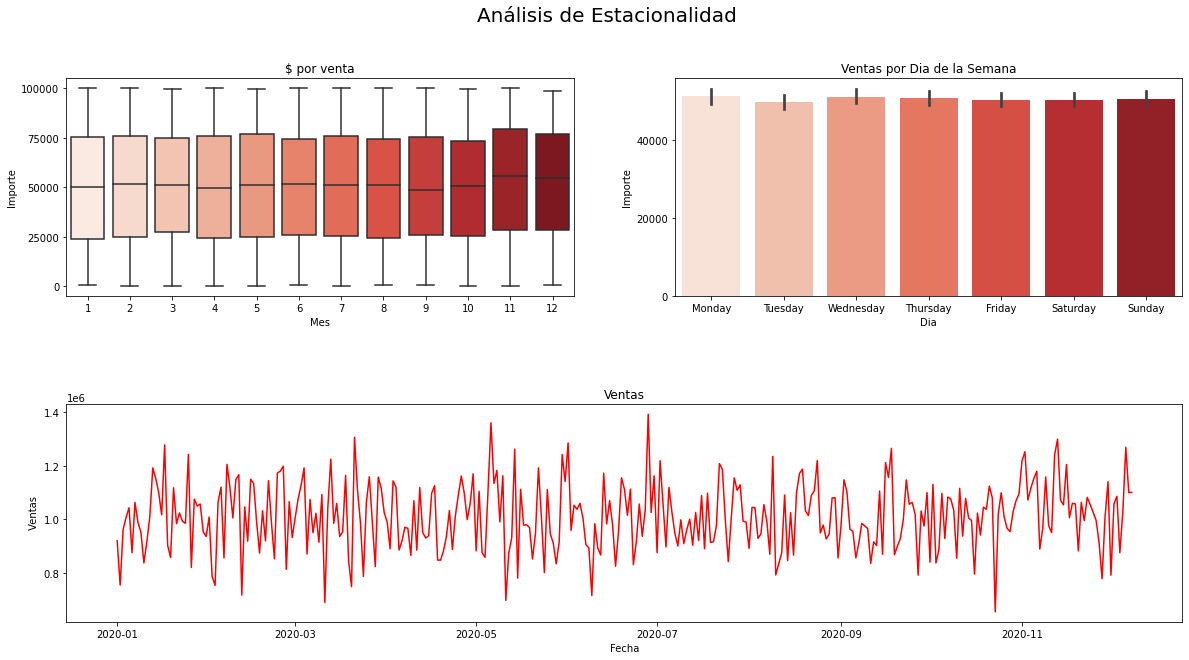

In [18]:
fig = plt.figure(1)
plt.suptitle('Análisis de Estacionalidad',fontsize=20)
gridspec.GridSpec(2,2)

# Subplot Pequeño
plt.subplot2grid((2,2), (0,0), colspan=1, rowspan=1)
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)
plt.title('$ por venta')
plt.xlabel('Mes')
plt.ylabel('Importe $')
sns.boxplot(data=df_ventas, x='Mes', y='Importe', palette='Reds')

# Subplot Pequeño
plt.subplot2grid((2,2), (0,1), colspan=1, rowspan=1)
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)
plt.title('Ventas por Dia de la Semana')
plt.xlabel('Ventas')
plt.ylabel('Dia')
sns.barplot(data=df_ventas, x='Dia',y='Importe',palette='Reds', order=['Monday','Tuesday','Wednesday',
                                                                         'Thursday','Friday','Saturday','Sunday'])

# Subplot Largo
plt.subplot2grid((2,2), (1,0), colspan=2, rowspan=1)
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)
plt.title('Ventas')
plt.xlabel('Fecha')
plt.ylabel(' Ventas')
sns.lineplot(data=df_ventas.groupby('Fecha')['Importe'].sum()
             ,color='r')

#Ajustando el plot
fig.set_size_inches(w=20,h=10)
plt.subplots_adjust(hspace=.5)
plt.show()


De lo observado en el gráfico, **no vemos estacionalidad significativa** que pueda influir sobre nuestras ventas.
Durante noviembre, las ventas en promedio son ligeramente mayores, lo cual tiene sentido si pensamos que mucha gente se anticipa a la compra de regalos de fin de año y fiestas.

### Analisis por Zona

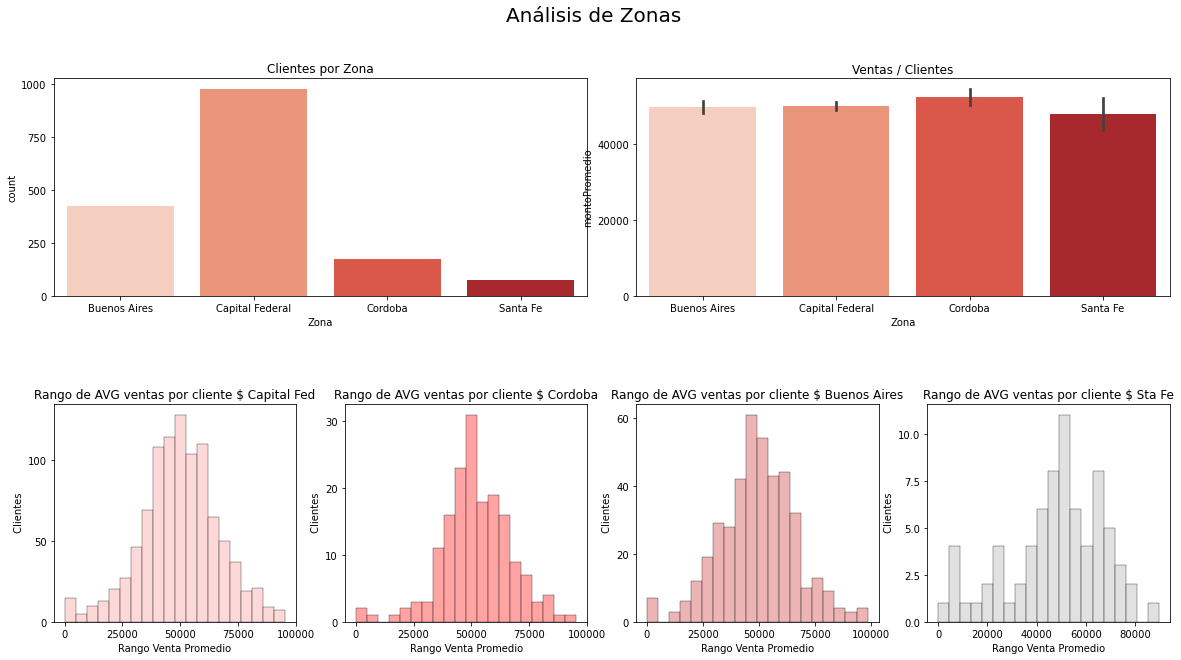

In [19]:
fig = plt.figure(1)
plt.suptitle('Análisis de Zonas',fontsize=20)
gridspec.GridSpec(2,4)

# Subplot Pequeño
plt.subplot2grid((2,4), (0,0), colspan=2, rowspan=1)
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)
plt.title('Clientes por Zona')
plt.xlabel('Zona')
plt.ylabel('Clientes')
sns.countplot(data=clientes_final, x='Zona', palette='Reds')

# Subplot Pequeño
plt.subplot2grid((2,4), (0,2), colspan=2, rowspan=1)
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)
plt.title('Ventas / Clientes')
plt.xlabel('Zona')
plt.ylabel('Monto promedio')
sns.barplot(data=clientes_final, x='Zona', y='montoPromedio', palette='Reds')

# Subplot Capital Federal
plt.subplot2grid((2,4), (1,0), colspan=1, rowspan=1)
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)
plt.title('Rango de AVG ventas por cliente $ Capital Fed')
plt.xlabel('Rango Venta Promedio')
plt.ylabel(' Clientes')
sns.histplot(data=clientes_final.loc[clientes_final['Zona']=='Capital Federal'], x='montoPromedio',bins=20,color='#FBCCCC')

# Subplot Cordoba
plt.subplot2grid((2,4), (1,1), colspan=1, rowspan=1)
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)
plt.title('Rango de AVG ventas por cliente $ Cordoba')
plt.xlabel('Rango Venta Promedio')
plt.ylabel(' Clientes')
sns.histplot(data=clientes_final.loc[clientes_final['Zona']=='Cordoba'], x='montoPromedio',bins=20,color='#FF8585')

# Subplot Buenos Aires
plt.subplot2grid((2,4), (1,2), colspan=1, rowspan=1)
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)
plt.title('Rango de AVG ventas por cliente $ Buenos Aires')
plt.xlabel('Rango Venta Promedio')
plt.ylabel(' Clientes')
sns.histplot(data=clientes_final.loc[clientes_final['Zona']=='Buenos Aires'], x='montoPromedio',bins=20,color='#E69B9B')

# Subplot Santa Fe
plt.subplot2grid((2,4), (1,3), colspan=1, rowspan=1)
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)
plt.title('Rango de AVG ventas por cliente $ Sta Fe')
plt.xlabel('Rango Venta Promedio')
plt.ylabel(' Clientes')
sns.histplot(data=clientes_final.loc[clientes_final['Zona']=='Santa Fe'], x='montoPromedio',bins=20, color='#D7D7D7')

#Ajustando el plot
fig.set_size_inches(w=20,h=10)
plt.subplots_adjust(hspace=.5)
plt.show()


Al analizar en conjunto las 4 zonas en las cuales tenemos influencia, podemos notar como **capital federal** concentra la mayor cantidad de ventas y clientes.

Sin embargo, si relativizamos la totalidad de ventas sobre los clientes de cada región, podemos ver como en **Córdoba** tenemos un mayor gasto por cliente. De mantenerse esta relación de forma lineal, si realizamos un mayor esfuerzo por posicionarnos en dicha provincia, podríamos aumentar significativamente nuestras ventas totales.

Por otro lado, estamos presentando bajos niveles de ventas en **Santa Fe**, con lo cual debemos prestar especial atención si no queremos perder participación en el mercado.

## Analisis de Clusters <a class="anchor" id="Clusters"></a>

Para el analisis de clusters, utilizaremos la librería **KMeans** , y dado que el algoritmo trabaja con distancias, llevaremos todas las features a una escala comun con **feature scaler**

Para entrenar el algoritmo, nos quedaremos con un subset de la base de clientes, formada por las features de 
* 'cantidadCompras'
* 'totalGastado'
* 'diasUltimaCompra'
* 'montoPromedio'
* 'diasPromedioCompra'

In [20]:
X_cluster = clientes_final.set_index('Cliente')[['cantidadCompras','totalGastado','diasUltimaCompra','montoPromedio','diasPromedioCompra']]
scaler=StandardScaler() ##instanciamos nuestro escalador
X_cluster_scaled=scaler.fit_transform(X_cluster); # aplicamos la transformacion a las features

* Calculo de la suma de distancias cuadráticas

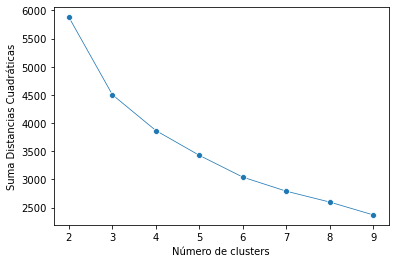

In [21]:
sq_distances=[]
k_values=range(2,10);

for k in k_values:
    kmeans=KMeans(n_clusters=k,n_init=10,random_state=0) # Numero de repeticiones=10
    kmeans.fit(X_cluster_scaled)
    sq_distances.append(kmeans.inertia_)

sns.lineplot(x=k_values,y=sq_distances,marker='o',size=30,legend=False);
plt.ylabel('Suma Distancias Cuadráticas');plt.xlabel('Número de clusters');   

* Calculo del silohuette Score:

El valor del silohuette score es una medida de cuán similar es un objeto a su propio cluster en comparación con otros. 
El score va de -1 a +1, donde un valor alto indica que el objeto está bien emparejado con su propio grupo y mal emparejado con los grupos vecinos.

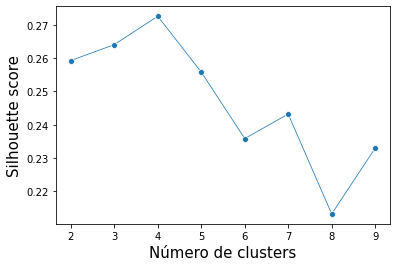

In [22]:
from sklearn.metrics import silhouette_score,silhouette_samples

sil=[]
k_values=range(2,10);

for k in k_values:
    kmeans=KMeans(n_clusters=k,n_init=10,random_state=0) # Numero de repeticiones=10
    kmeans.fit(X_cluster_scaled)
    score=silhouette_score(X_cluster_scaled,kmeans.labels_)
    sil.append(score)

sns.lineplot(x=k_values,y=sil,marker='o',size=30,legend=False);
plt.ylabel('Silhouette score',fontsize=15);plt.xlabel('Número de clusters',fontsize=15);

Como vemos en ambos gráficos, el punto de inflexion se da al nivel de 4 clusters, lo cual sugiere (en principio) un optimo para entrenar nuestro modelo.

In [23]:
kmeans=KMeans(n_clusters=4,n_init=10,random_state=0) # Numero de repeticiones=10
kmeans.fit(X_cluster_scaled)

KMeans(n_clusters=4, random_state=0)

In [24]:
labels=kmeans.labels_ ##Nos guardamos un array con las predicciones, para utilizarlo como colores en el grafico

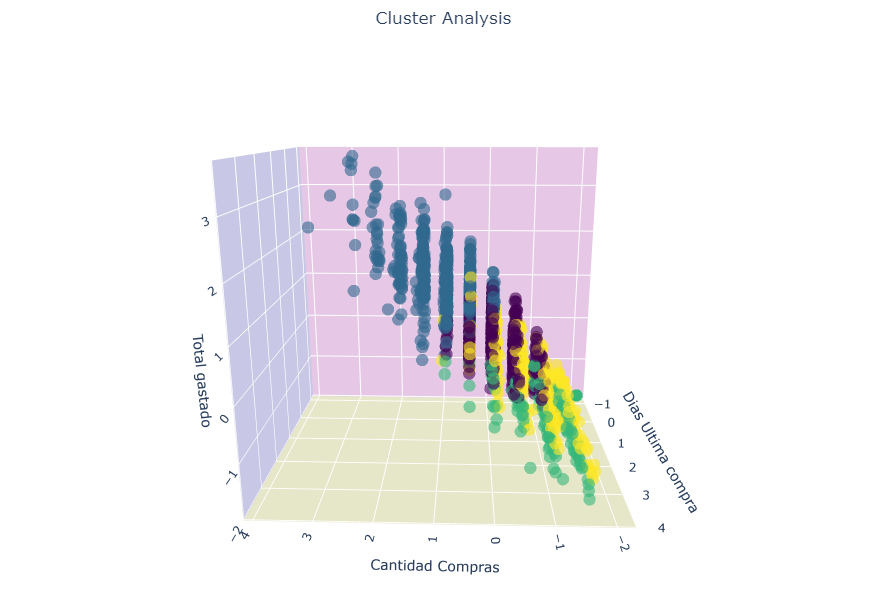

In [36]:
fig = go.Figure(data=[go.Scatter3d(x=X_cluster_scaled[:,0],y=X_cluster_scaled[:,2],z=X_cluster_scaled[:,1],mode='markers',
                                   hovertext=labels,
                                   marker = dict( size = 7, 
                                                 color = labels, 
                                               colorscale ='Viridis', 
                                               opacity = 0.6
                                                ))])
fig.update_layout(title=dict(text="Cluster Analysis", x=0.5,y=.98),
                   scene = dict(
                    xaxis = dict(
                         backgroundcolor="rgb(200, 200, 230)",
                         gridcolor="white",
                         showbackground=True,
                         zerolinecolor="white",
                         title='Cantidad Compras',),
                    yaxis = dict(
                        backgroundcolor="rgb(230, 200,230)",
                        gridcolor="white",
                        showbackground=True,
                        zerolinecolor="white",
                        title='Dias Ultima compra',),
                    zaxis = dict(
                        backgroundcolor="rgb(230, 230,200)",
                        gridcolor="white",
                        showbackground=True,
                        zerolinecolor="white",
                        title='Total gastado',),),
                    width=600,
                    height=600,
                    margin=dict(
                    r=0, l=0,
                    b=10, t=30)
                  )
fig.show()

Como podemos ver en el grafico, tenemos 4 clusters diferentes caracterizados por:

|Cluster|Color|Descripcion|
| :-: | :-: | :-: |
|Cluster 0| Violeta | Consumidores con pocas compras pero muy recientes. Bajo total gastado|
|Cluster 1| Azul| Consumidores con muchas compras y monto total gastado. Presentan a su vez compras recientes|
|Cluster 2| Verde| Consumidores que se caracterizan por pocas compras y bajos montos. No existe mayor diferencia en tiempo desde ultima compra|
|Cluster 3| Amarillo| Consumidores con pocas compras pero montos intermedios. Se puede notar una tendencia a muchos dias desde la ultima compra|

<mark style="background-color: pink">Cluster 0</mark>, **Potenciales Estrellas** - Son clientes que tienen poco monto gastado, pero compras muy recientes. Puede tratarse tanto de clientes nuevos, como clientes pequeños pero constantes. Podemos desarrollar campañas de promociones y descuentos que alienten a adquirir mayores cantidades de nuestro producto.

<mark style="background-color: lightblue">Cluster 1</mark>, **Clientes Estrella** - Son aquellos clientes fieles, que están activos (ya que las compras distan desde hace poco), y que invierten mucho en nuestros productos. Hay que prestar especial atención a sus patrones de consumo, ya que podrían darnos nuevas ideas para expandir nuestro negocio.

<mark style="background-color: lightgreen">Cluster 2</mark>, **Cliente Ocasional** - Poseen pocas compras, bajo monto, y no se ve un patron común en la antiguedad de la última compra. Parecen ser clientes ocasionales, que probaron nuestros productos pero por algun motivo no retornaron más veces. Es importante evaluar la experiencia de compra de este tipo de usuarios, para detectar oportunidades de mejora.

<mark style="background-color: lightyellow">Cluster 3</mark>, **Cliente Promedio** - Poseen pocas compras, pero montos intermedios en las mismas. Muchos de ellos presentan muchos dias desde la ultima compra, con lo cual pueden ser clientes inactivos. Nuestro objetivo podría ser tratar de recuperarlos, con campañas de email marketing y atracción.





## Dashboard <a class="anchor" id="Dashboard"></a>

Para confeccionar el dashboard, utilizaremos tableau y tomaremos como base de partida los dos dataset finales de Ventas y Clientes, para lo cual los cuardaremos en un nuevo csv.

In [37]:
# Quitar los # para guardar los csv de manera local
#clientes_final.to_csv('clientesFinal1.csv')
#df_ventas.to_csv('ventasFinal1.csv')

In [38]:
%%HTML

<div class='tableauPlaceholder' id='viz1618794897532' style='position: relative'><noscript><a href='#'><img alt='Desafío Técnico - Análisis de Ventas ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;De&#47;Desafio_16187107007150&#47;Historia1&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='Desafio_16187107007150&#47;Historia1' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;De&#47;Desafio_16187107007150&#47;Historia1&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='es' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1618794897532');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='1016px';vizElement.style.height='991px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

Para una mejor visualización del Dashboard Final, puede consultarlo en el siguiente link:

https://public.tableau.com/views/Desafio_16187107007150/Historia1?:language=es&:display_count=y&publish=yes&:origin=viz_share_link

## Conclusiones

* En nuestra base de datos, tenemos **usuarios que nunca realizaron compras**. Potenciales clientes, ya que demostraron tener intención de compra pero no concretaron la misma. Se podría trabajar en campañas de atracción por el lado de promociones o descuentos por "primera compra".
* Nuestros usuarios se pueden **segmentar** en **4 grupos** con características bien definidas. Sería importante dasarrollar una **estrategia acorde a cada segmento**, para maximizar el rendimiento del negocio.
* Si bien en **Capital Federal** concentramos la mayor cantidad de ventas, existen interesantes oportunidades en **Córdoba**, en donde los clientes y las ventas totales son menores, pero las cantidades que en promedio gasta cada usuario es mayor. Si implementamos una estrategia de posicionamiento en el mercado Cordobes, podríamos aumentar considerablemente el rendimiento.
* Especial atención al caso de **Santa Fe**, cuyas bajas ventas podrían ser indicios de una pérdida de participación en el mercado.

<img src = 'https://i.pinimg.com/originals/e5/cf/e8/e5cfe886d82013aedc2c9061a5c712c4.jpg' >